In [46]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from tqdm import tqdm
from tensorflow.keras.utils import to_categorical 

In [47]:
DATADIR = "D:/Sign Language Detection/Numeric Sign Data/"

In [48]:
categories = os.listdir(DATADIR)
categories

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

(93, 100, 3)

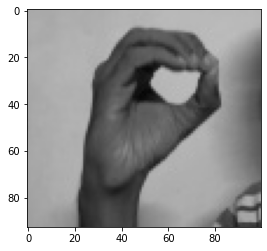

In [49]:
sample_image = 'D:/Sign Language Detection/Numeric Sign Data/0/zero_17.jpg'
img_array = cv2.imread(sample_image)  # convert to array
plt.imshow(img_array)
img_array.shape

In [72]:
data = []

def create_dataset():
    categories = os.listdir(DATADIR)
    for category in categories:
        path = os.path.join(DATADIR,category)  
        class_num = categories.index(category)
        
        for img in tqdm(os.listdir(path)):
            try:
                img_array = cv2.imread(os.path.join(path,img)) # ,cv2.IMREAD_GRAYSCALE)  # convert to array
                #rgb = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
                rsz=cv2.resize(img_array, (60, 60))
                data.append([rsz, class_num])  # add this to our training_data
                #plt.axis('off')
                #plt.imshow(rsz)
                #plt.savefig("ragresize.png")
                #break
            except Exception as e:  # in the interest in keeping the output clean...
                pass
    return data



In [73]:
%%time
data = create_dataset()

print(len(data))

100%|████████████████████████████████████████████████████████████████████████████| 1501/1501 [00:00<00:00, 3929.95it/s]

15000
Wall time: 3.92 s


In [74]:
X = []
Y = []

for features,label in data:
    X.append(features)
    Y.append(label)

In [75]:
X = np.array(X)
Y = np.array(Y)

In [76]:
X.shape

(15000, 60, 60, 3)

In [77]:
from sklearn.model_selection import train_test_split
X_data, X_test, Y_data, Y_test = train_test_split(X, Y,test_size=0.10, random_state = 41,stratify=Y)

In [78]:
X_train,X_val, Y_train, Y_val = train_test_split(X_data, Y_data,test_size=0.20, random_state = 41)

In [79]:
def normalizaze_data(X):
    X_data = []
    for data in X:
        data = data / 255
        X_data.append(data)
    return np.array(X_data)

In [80]:
%%time
x_train = normalizaze_data(X_train)
x_val = normalizaze_data(X_val)
x_test = normalizaze_data(X_test)

Wall time: 1.58 s


In [81]:
x_train = x_train.reshape(-1, 60, 60, 3)
x_val = x_val.reshape(-1, 60, 60, 3)
x_test = x_test.reshape(-1, 60, 60, 3)

In [ ]:
0===>>> [1,0,0,0,0,0,0,0,0,0]
1===>>>[0,1,0,0,0,0,0,0,0,0]

In [82]:
%%time
y_train =to_categorical(Y_train)
y_val = to_categorical(Y_val)
y_test =to_categorical(Y_test)

Wall time: 1.99 ms


In [83]:
print(f"x_train.shape: {x_train.shape}")
print(f"y_train.shape: {y_train.shape}")
print(f"x_val.shape: {x_val.shape}")
print(f"y_val.shape: {y_val.shape}")
print(f"x_test.shape: {x_test.shape}")
print(f"y_test.shape: {y_test.shape}")

x_train.shape: (10800, 60, 60, 3)
y_train.shape: (10800, 10)
x_val.shape: (2700, 60, 60, 3)
y_val.shape: (2700, 10)
x_test.shape: (1500, 60, 60, 3)
y_test.shape: (1500, 10)


In [84]:
#importing other required libraries
import numpy as np
import pandas as pd
import pickle
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from keras import Sequential
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.layers import Flatten,Dense,BatchNormalization,Activation,Dropout
from tensorflow.keras.utils import to_categorical
from keras import losses, models, optimizers
import time
from tensorflow.keras.layers import Input,Dense, Dropout, Activation, Flatten,concatenate
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from keras.layers import (Convolution2D, Dense,Flatten, Dropout, GlobalAveragePooling2D,GlobalMaxPool2D, 
                          Input, MaxPool2D, concatenate)
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import (EarlyStopping, LearningRateScheduler,
                             ModelCheckpoint, TensorBoard, ReduceLROnPlateau)

In [85]:
tf.optimizers.Adam()

In [86]:
input_dim = x_train.shape[1:]
num_class = 10
MAX_PATIENT =5
MAX_EPOCHS = 150
batch_size = 64
lr = 0.001

In [87]:
%%time
def CNN_Baseline(input_dim,num_class):
    inputs = Input(shape=input_dim)
    x = Convolution2D(64, (3, 3), activation = "relu") (inputs)
    x = MaxPool2D(pool_size=(2, 2)) (x)
    x =(Dropout(0.5))(x)
    
    x = Convolution2D(128, (3, 3), activation = "relu") (x)
    x = MaxPool2D(pool_size=(2, 2)) (x)
    x =(Dropout(0.5))(x)
   
    x = Convolution2D(128, (3, 3), activation = "relu") (x)
    x = MaxPool2D(pool_size=(2, 2)) (x)
    x =(Dropout(0.5))(x)
    
    x = Flatten()(x)
    
    x = Dense(100, activation = "relu") (x)
    x =(Dropout(0.5))(x)
    outputs = Dense(num_class, activation='softmax')(x)
    model = Model(inputs, outputs)
    
    return model 

model = CNN_Baseline(input_dim,num_class)


Wall time: 271 ms


In [88]:
opt = tf.optimizers.Adam(lr)

model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

checkpoint = ModelCheckpoint('Models/model_seed_41.h5', monitor='val_loss', verbose=1, save_best_only=True)
early = EarlyStopping(monitor="val_loss", mode="min", patience=MAX_PATIENT)
ReduceLR = ReduceLROnPlateau(monitpr = 'val_loss',factor=0.1,patience=3, verbose=1)
callbacks_list = [checkpoint,ReduceLR, early]

print("[INFO] Training Start---------please Wait")
history_1 = model.fit(x_train, y_train, 
                    batch_size = batch_size,epochs = MAX_EPOCHS, 
                    validation_data =(x_val, y_val),
                    verbose = 1,callbacks = callbacks_list)
print("[INFO] Training Finished!!!")


[INFO] Training Start---------please Wait
Epoch 1/150
169/169 [==============================] - ETA: 0s - loss: 2.3035 - accuracy: 0.1084
Epoch 00001: val_loss improved from inf to 2.28068, saving model to Models\model_seed_41.h5
169/169 [==============================] - 98s 576ms/step - loss: 2.3035 - accuracy: 0.1084 - val_loss: 2.2807 - val_accuracy: 0.1478 - lr: 0.0010
Epoch 2/150
169/169 [==============================] - ETA: 0s - loss: 2.0175 - accuracy: 0.2724
Epoch 00002: val_loss improved from 2.28068 to 1.51063, saving model to Models\model_seed_41.h5
169/169 [==============================] - 92s 545ms/step - loss: 2.0175 - accuracy: 0.2724 - val_loss: 1.5106 - val_accuracy: 0.6007 - lr: 0.0010
Epoch 3/150
169/169 [==============================] - ETA: 0s - loss: 1.4231 - accuracy: 0.5090
Epoch 00003: val_loss improved from 1.51063 to 0.85292, saving model to Models\model_seed_41.h5
169/169 [==============================] - 94s 559ms/step - loss: 1.4231 - accuracy: 0.50

In [89]:
%%time
score = model.evaluate(x_train, y_train, batch_size = 64)
print('training score: ', score)

score = model.evaluate(x_val, y_val, batch_size = 64)
print('validation score: ', score)

score = model.evaluate(x_test, y_test, batch_size = 64)
print('test score: ', score)

169/169 [==============================] - 20s 117ms/step - loss: 0.0246 - accuracy: 0.9958
training score:  [0.024598075076937675, 0.9958333373069763]
43/43 [==============================] - 5s 111ms/step - loss: 0.0825 - accuracy: 0.9756
validation score:  [0.08247757703065872, 0.9755555391311646]
24/24 [==============================] - 3s 113ms/step - loss: 0.0850 - accuracy: 0.9807
test score:  [0.08499466627836227, 0.9806666374206543]
Wall time: 28.8 s


In [69]:
def plot_curve(history,fig_name):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)
    
    plt.figure(figsize=(10,10))
    plt.grid()
    plt.title('Training and validation Curve')
    plt.plot(epochs, acc, 'b',marker='o', label='Training acc')
    plt.plot(epochs, val_acc, 'r',marker='o', label='Validation acc')
    plt.legend()
    plt.plot(epochs, loss, 'm',marker='o', label='Training loss')
    plt.plot(epochs, val_loss, 'g',marker='o', label='Validation loss')
    plt.legend()
    #plt.savefig(f"Figures/{fig_name}.png")
    plt.show()
    

FileNotFoundError: [Errno 2] No such file or directory: 'Figures/fig_name_41.png'

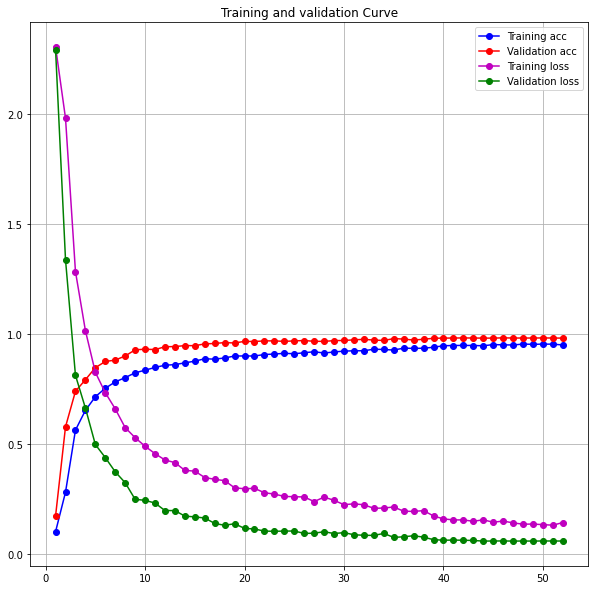

In [70]:
plot_curve(history_1,'fig_name_41')

In [18]:
from keras.models import load_model

In [19]:
model = load_model("Models/model_seed_41.h5")

3

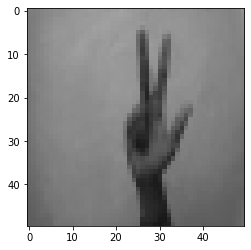

In [38]:
plt.imshow(X_test[1])

In [40]:
predict_x = model.predict(x_test) 
classes_x = np.argmax(predict_x,axis=1)

4
4


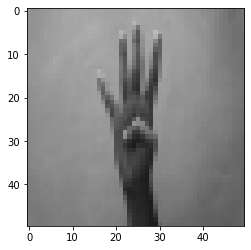

In [45]:
x = 8
print(Y_test[x])
print(classes_x[x])
plt.imshow(X_test[x])